In [20]:
import pandas as pd
import os
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

%matplotlib inline

In [2]:
parquet_path = r'C:\Users\catth\OneDrive\Documents\Data\df_selected.parquet'
df = pd.read_parquet(parquet_path)
df.head()

,category_code,brand,price,hour,label,previously_purchased_brand
0,appliances.personal.massager,philips,257.380005,4,0,0
1,appliances.personal.massager,artel,167.210007,4,0,0
2,apparel.shoes.slipons,lenovo,179.899994,2,0,0
3,apparel.shoes.slipons,prestigio,97.559998,4,0,0
4,apparel.shoes.slipons,huawei,192.770004,4,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52334247 entries, 0 to 52334246
Data columns (total 6 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   category_code               object 
 1   brand                       object 
 2   price                       float32
 3   hour                        int32  
 4   label                       int64  
 5   previously_purchased_brand  int64  
dtypes: float32(1), int32(1), int64(2), object(2)
memory usage: 1.9+ GB


## Encode categorical features

In [4]:
for col in ['brand', 'category_code']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [5]:
df.head()

,category_code,brand,price,hour,label,previously_purchased_brand
0,54,2998,257.380005,4,0,0
1,54,274,167.210007,4,0,0
2,19,2219,179.899994,2,0,0
3,19,3085,97.559998,4,0,0
4,19,1768,192.770004,4,0,0


## Features and labels

In [6]:
X = df.drop('label', axis=1)
y = df['label']

## Train-test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Train XGBoost

In [8]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [16]:
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [17]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [18]:
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

## confusion matrix

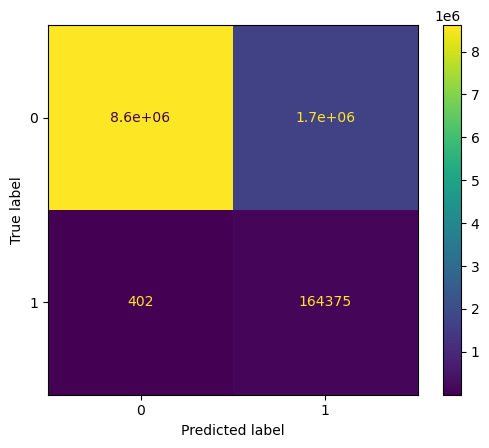

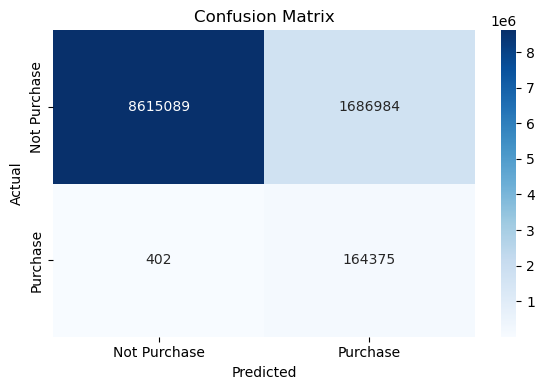

In [13]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Purchase', 'Purchase'], yticklabels=['Not Purchase', 'Purchase'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## ROC curve

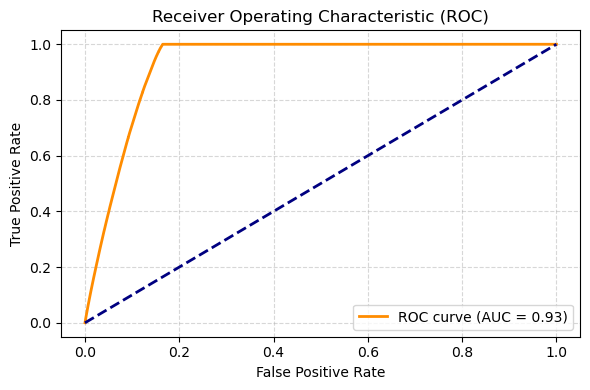

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [26]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

roc_auc = roc_auc_score(y_test, y_proba)

report_df.loc['ROC AUC'] = pd.Series({'F1-Score': None, 'Precision': None, 'Recall': None, 'Support': None})
report_df.loc['ROC AUC', 'ROC AUC'] = roc_auc  # Thêm cột mới tên 'ROC AUC'

report_df = report_df.rename(columns={
    'precision': 'Precision',
    'recall': 'Recall',
    'f1-score': 'F1-Score',
    'support': 'Support'
})

print(report_df.round(3))

              Precision  Recall  F1-Score       Support  ROC AUC
0                 1.000   0.836     0.911  1.030207e+07      NaN
1                 0.089   0.998     0.163  1.647770e+05      NaN
accuracy          0.839   0.839     0.839  8.390000e-01      NaN
macro avg         0.544   0.917     0.537  1.046685e+07      NaN
weighted avg      0.986   0.839     0.899  1.046685e+07      NaN
ROC AUC             NaN     NaN       NaN           NaN     0.93
